# Make train dataset

In [1]:
# !pip install wikipedia-api

In [1]:
import re
import json
import random
from collections import deque
import numpy as np
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
from matplotlib import font_manager
from fontTools.ttLib import TTFont

from PIL import Image, ImageDraw, ImageFont, ImageOps
from sklearn.feature_extraction.text import CountVectorizer
import wikipediaapi

import nltk
from nltk.tokenize import sent_tokenize

from castom_utils import *

## Config

In [2]:
CFG = load_config()

Config is loaded!
A list of all characters used:
0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €₽№°АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


## Text parsing

Для обучения модели распознавания текста текста с изображений нам понадобится тренировочный и валидационный датасеты.  
Так как задача состоит в распознавании печатного текста, то тренировочные данные можно синтетически сгенерировать. В качестве источников текстовых данных используем API Википедии, откуда спарсим случайные русскоязычные статьи.

In [6]:
def _clean_text(text: list):
    """
    Очищает текст, оставляя только слова, состоящие из символов из списка character.
    Удаляет слова, содержащие хотя бы один символ не из списка.
    """
    valid_char_regex = re.compile(f"[{re.escape(CFG.vocab)}]+")
    
    text = text.strip()
    # Заменяем последовательности пробелов, табуляций, переносов строк на один пробел
    text = re.sub(r'\s+', ' ', text)
    # Удаляем диакритические знаки
    text = re.sub(r'[\u0300-\u036f]+', '', text)
    # Разбиваем текст на слова
    words = text.split(' ') 
    # Оставляем только слова, которые полностью соответствуют списку символов
    valid_words = [word for word in words if valid_char_regex.fullmatch(word)]
    # Перезаписываем очищенную строку
    text = ' '.join(valid_words)

    return text

In [7]:
def _get_wikipedia_text(page):
    # Разбиваем статью по переносу строки
    text = page.text
    return _clean_text(text)

In [8]:
def parsing_wikipedia_articles(
    root_topic: list, 
    language='ru', 
    max_articles=5, 
    search_depth=3,
    num_workers=None
):
    """
    Парсинг случайных статей из Википедии по заданной тематике.
    """
    wiki = wikipediaapi.Wikipedia('Wikipedia-API', language)
    articles = []  # Список текстов статей
    visited_topics = set()  # Для отслеживания уже посещённых тем
    queue = deque(root_topic)  # Очередь для обхода связанных тем
    search_depth += len(root_topic)
    cnt_add_queue = 0

    # Распараллеливание процессов
    progress_bar = tqdm(total=max_articles, desc='Making list of articles')
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        while queue and len(visited_topics) < max_articles:
            # Берем название статьи из начала очереди
            current_topic = queue.popleft()

            # Пропускаем посещенные статьи
            if current_topic in visited_topics:
                continue

            # Загрузка текущей страницы
            page = wiki.page(current_topic)
            if page.exists():
                # Добавляем страницу в очередь на обработку во многопотоке
                futures.append(executor.submit(_get_wikipedia_text, page))
                
                # Добавляем статью в список посещенных
                visited_topics.add(current_topic)

                # Добавление связанных статей в очередь
                if cnt_add_queue <= search_depth:
                    links = list(page.links.keys())
                    queue.extend(links)
                    cnt_add_queue += 1
                    # Если мы прошлись по всем статьям из списка root_topic,
                    # то случайным образом перемешиваем очередь статей
                    if cnt_add_queue >= len(root_topic):
                        random.shuffle(queue)

                progress_bar.update(1)

        # Обработка результатов
        for future in tqdm(futures, desc='Articles parsing'):
            text = future.result()
            articles.append(text)

    # INFOMATION
    visited_topics = list(visited_topics)
    sample_topics = np.random.choice(
        visited_topics, 
        size=min(10, len(visited_topics)), 
        replace=False
    ).tolist()

    sample_topics = [f' - {word}' for word in sample_topics]

    print(f'{Ansi.bold}Несколько случайных названий загруженных статей:{Ansi.end}')
    print('\n'.join(sample_topics))
    
    return articles

Важный момент, по умолчанию векторайзеры из sklearn отбрасывают знаки пунктуации, которые должна уметь распознавать модель. Поэтому меняем регулярное выражение в **token_pattern**, что бы сохранить пунктуацию в тексте.

In [9]:
def text_split(texts: list, max_length=20, ngram_range=(2, 5), token_pattern=r"\S+"):
    """
    Разбивает текст на фразы с использованием CountVectorizer для генерации n-грамм.
    """
    vectorizer = CountVectorizer(
        ngram_range=ngram_range, 
        analyzer='word', 
        lowercase=False,
        token_pattern=token_pattern,
        stop_words=None
        )
    _ = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()

    # Отбираем n-граммы, которые не превышают max_length
    filtered_phrases = [
        ngram for ngram in ngrams if len(ngram) <= max_length
    ]

    # INFO
    random_phrases = random.choices(filtered_phrases, k=10)
    random_phrases = [f' - {word}' for word in random_phrases]

    print(f'Сформировано различных фраз: {Ansi.bold}{len(filtered_phrases)}{Ansi.end}\n')
    print(f'{Ansi.bold}Несколько случайных фраз:{Ansi.end}')
    print('\n'.join(random_phrases))
    
    return filtered_phrases

In [10]:
# Парсинг статей из Википедии
articles = parsing_wikipedia_articles(
    ['Наука', 'Образование', 'Математика', 'Физика'], #'Греческий алфавит'
    max_articles=100
)

Making list of articles:   0%|          | 0/100 [00:00<?, ?it/s]

Articles parsing:   0%|          | 0/100 [00:00<?, ?it/s]

Несколько случайных названий загруженных статей:
 - Общественные науки
 - Начальная школа
 - Математическое доказательство
 - Кандидат наук
 - Сурдин, Владимир Георгиевич
 - Алгебраическая кривая
 - Кириллическая система счисления
 - Премия Крафорда
 - Список физических журналов
 - История математики


Нарезаем текст на отдельные слова для обучения recognition model

In [11]:
# Предобработка текста
phrases = text_split(
    articles,
    max_length=27, 
    ngram_range=(1, 1)
)

Сформировано различных фраз: 46018

Несколько случайных фраз:
 - крупнейшему
 - издававшаяся
 - Солнца.
 - взяты
 - Альманах.
 - Бонхёффером.
 - проходила
 - водится
 - христианской
 - сейчас


## Fonts

In [12]:
def _is_supported_chars(font_path, unicode_list):
    """
    Проверяет, поддерживает ли шрифт все нужные символы
    """
    try:
        font = TTFont(font_path)
        cmap = font['cmap'].getBestCmap()
        for code in unicode_list:
            if code not in cmap:
                return False
        return True
    except:
        return False


def valid_fonts(fonts_list: list, unicode_list: list):
    """
    Отбирает из списка шрифты, поддеривающие все необходимые символы
    """
    return [font for font in fonts_list if _is_supported_chars(font, unicode_list)]


def get_system_fonts():
    """
    Возвращает список системных шрифтов
    """
    # Получаем список всех шрифтов, установленных в системе
    fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')  # Системные шрифты
    return fonts


def get_fonts_from_folder(path: str):
    """
    Возвращает список шрифтов из папки
    """
    path = Path(path)
    fonts = path.rglob('*.ttf')
    return [str(font) for font in fonts]

Получим список системных шрифтов, поддерживающих все символы, которые нам необходимо уметь распознавать.  
Так же можно загрузить шрифты, к примеру с  [Google fonts](https://fonts.google.com/) и так же их использовать.  
При генерации каждого отдельного изображения будем случайно выбирать один из доступных шрифтов.  
Различные случайные аугментации (шум, искажения, изменение яркости и т.д) будут применяться непосредственно при обучении моделей.

In [13]:
# Получим список кодов unicode для всех заранее определенных символов, 
vocab_unicode = list(map(ord, CFG.vocab))

# Загрузим скачанные шрифты. Так же можно использовать системные
total_fonts = get_fonts_from_folder(CFG.path_fonts) # + get_system_fonts()

# Отберем только те шрифты, которые поддерживают все необходимые нам символы
good_fonts = valid_fonts(total_fonts, vocab_unicode)
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(good_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 279


In [145]:
# txt = 'съешь еще этих мягких французских булок'

# for font_path in good_fonts[:30]:
#     font = ImageFont.truetype(font_path, size=30)
#     bbox = font.getbbox(txt)
#     text_width = bbox[2] - bbox[0]
#     text_height = bbox[3] - bbox[1]
    
#     img = Image.new('L', (text_width, text_height), color=255)
#     draw = ImageDraw.Draw(img)
#     draw.text((0, -bbox[1]), txt, font=font)

#     print(font_path)
#     plt.imshow(img, cmap='gray')
#     plt.show()

## Generating images for recognition

Текстовая информация получена. Далее на ее основе сгенерируем изображения и составим датасет, где каждой картинке будет соответствовать определенный текст

In [15]:
def _generate_recognition_image(i, text, font_path, output_dir):
    font_size = 30
    font = ImageFont.truetype(font_path, font_size)

    # Вычисление размеров текста
    bbox = font.getbbox(text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Создание пустого изображения
    background_color = tuple(random.randint(250, 255) for _ in range(3)) # Случайный цвет
    img = Image.new('RGB', (text_width, text_height), color=background_color)
    draw = ImageDraw.Draw(img)

    # Отрисовка текста
    text_color = tuple(random.randint(0, 40) for _ in range(3)) # Случайный цвет
    draw.text((0, -bbox[1]), text, fill=text_color, font=font)

    # Добавляем случайные отступы с каждой из сторон
    margin = tuple(random.randint(0, 3) for _ in range(4)) # left, top, right, bottom
    img = ImageOps.expand(img, margin, fill=background_color)

    # Сохранение изображения
    img_name = f"text_{i:07d}.png"
    img_path = output_dir.joinpath('images', img_name)

    img.save(img_path)

    return img_name, text

In [16]:
def generate_recognition_dataset(output_dir, fonts, num_images, text_samples, num_workers=None):
    """
    Генерирует синтетический датасет из изображений.
    """
    output_dir.joinpath('images').mkdir(parents=True, exist_ok=True)
    annotations = {}

    # Распараллеливание процессов
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for i in range(num_images):
            # Случайный текст и шрифт
            font_path = random.choice(fonts)
            text = random.choice(text_samples)
            
            # С некоторой вероятностью пишем текст капсом
            if random.random() < .25:
                text = text.upper()
                
            futures.append(executor.submit(_generate_recognition_image, i, text, font_path, output_dir))
            
        # Обработка результатов
        for future in tqdm(futures, desc=f'Images generation "{output_dir.name}"'):
            img_name, text = future.result()
            annotations[img_name] = text

    # Сохранение аннотаций в json
    annotations_file = output_dir.joinpath('labels.json')
    with open(annotations_file, 'w', encoding='utf-8') as file:
        json.dump(annotations, file, indent=2, ensure_ascii=False)

Определяем размеры датасетов и генерируем изображения.

По идее и детектор этой модели можно натренировать, что бы он не учитывал формулы. Я просто еще не успел в этом вопросе разобраться. 

In [19]:
recognition_dataset = CFG.path_dataset_synthetic.joinpath('recognition')

In [22]:
train_size = 100000
val_size = 20000
test_size = 20000

generate_recognition_dataset(recognition_dataset.joinpath('train'), good_fonts, train_size, phrases)
generate_recognition_dataset(recognition_dataset.joinpath('val'), good_fonts, val_size, phrases)
generate_recognition_dataset(recognition_dataset.joinpath('test'), good_fonts, test_size, phrases)

Images generation "train":   0%|          | 0/100000 [00:00<?, ?it/s]

Images generation "val":   0%|          | 0/20000 [00:00<?, ?it/s]

Images generation "test":   0%|          | 0/20000 [00:00<?, ?it/s]

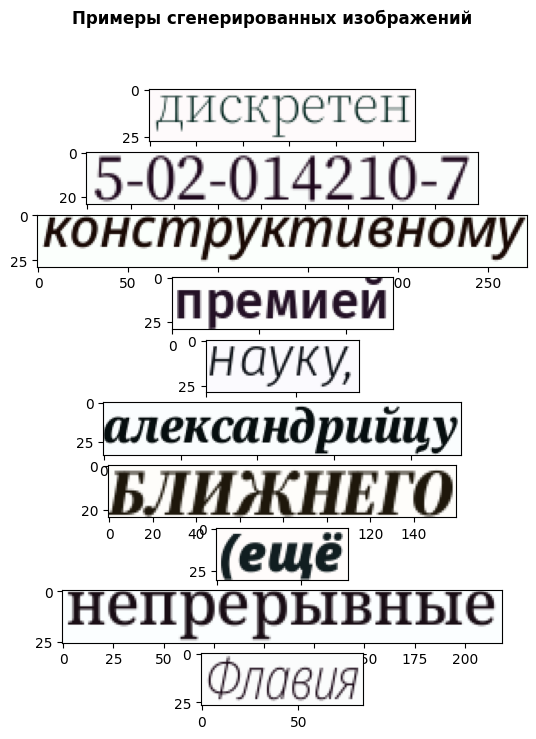

In [26]:
random_img = random.choices(list(recognition_dataset.joinpath('train').rglob('*.png')), k=10)

fig, axes = plt.subplots(len(random_img), figsize=(8, 8))
fig.suptitle('Примеры сгенерированных изображений', fontweight='bold')
for ax, path_img in zip(axes.flat, random_img):
    img = Image.open(path_img)
    ax.imshow(img)
    # ax.axis('off')
plt.show()

## Generating images for detection

Похожим образом сформируем датасет для detection model. Но теперь будем формировать целые страницы с разметкой bboxes для отдельных слов.  
Для генерирования текста будем брать несколько случайных статей загруженных с Википедии, разбивать на предложения, перемешивать получившиеся предложения, а затем из них составлять целый текст.

In [27]:
def _generate_recognition_image(i, output_dir, text, font_path, page_size, language):
    font_size = random.randint(18, 25)
    font = ImageFont.truetype(font_path, font_size)
    font_height = sum(font.getmetrics()) # Высота текста
    line_spacing = random.randint(0, 7)  # Межстрочный интервал

    # Случайный цвет для текста и фона
    background_color = tuple(random.randint(250, 255) for _ in range(3))
    text_color = tuple(random.randint(0, 40) for _ in range(3))
    # Создание пустого изображения
    img = Image.new('RGB', page_size, color=background_color)
    draw = ImageDraw.Draw(img)

    # Нарезаем текст на отдельные предложения
    sentences = sent_tokenize(text, language=language)
    # Удаляем короткие предложения
    sentences = [sent for sent in sentences if len(sent) > 50]
    # Случайным образом меняем порядок предложений
    random.shuffle(sentences)

    # Отступ координат разметки от края букв
    margin_box = 1
    # Добавляем случайные отступы с каждой из сторон
    margin = tuple(random.randint(5, 40) for _ in range(4)) # left, top, right, bottom
    # Начальная позиция для текста по вертикали
    y_offset = margin[1]

    polygons = []

    for sentence in sentences:
        # Начальная позиция по горизонтали
        x_offset = margin[0]

        # Разбиваем текст на слова
        words = sentence.split(' ')
        for word in words:
            bbox_word = font.getbbox(word)

            if x_offset + bbox_word[2] > page_size[0] - margin[2]:  # Если слово не помещается в строке
                y_offset += font_height + line_spacing
                x_offset = margin[0]

            if y_offset + font_height > page_size[1] - margin[3]:  # Если достигли конца страницы
                break

            # Отрисовываем слово
            draw.text((x_offset, y_offset), word, fill=text_color, font=font)
            #  Сохраняем его bounding box
            bbox = [
                [x_offset + bbox_word[0] - margin_box, y_offset + bbox_word[1] - margin_box],
                [x_offset + bbox_word[2] + margin_box, y_offset + bbox_word[1] - margin_box],
                [x_offset + bbox_word[2] + margin_box, y_offset + bbox_word[3] + margin_box],
                [x_offset + bbox_word[0] - margin_box, y_offset + bbox_word[3] + margin_box]
            ]
            polygons.append(bbox)

            # Обновляем отступ для следующего слова, учитывая длину пробела
            x_offset += bbox_word[2] + int(font.getlength(' '))

        # Переход на следующую строку
        y_offset += font_height + line_spacing
        if y_offset > page_size[1] - margin[3]:
            break

    img_name = f"page_{i:07d}.png"
    img_path = output_dir.joinpath('images', img_name)
    img.save(img_path)
    
    annotation = {
        'img_dimensions': page_size,
        'polygons': polygons
    }

    return img_name, annotation

In [28]:
def generate_detection_dataset(
    output_dir, 
    fonts, 
    articles, 
    num_pages, 
    page_size=(800, 1200), 
    language='russian',
    num_workers=None
):
    """
    Генерирует синтетический датасет страниц текста с bounding box для каждого слова.
    """
    output_dir.joinpath('images').mkdir(parents=True, exist_ok=True)
    annotations = {}

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for i in range(num_pages):
            # Случайный выбор шрифта
            font_path = random.choice(fonts)
            # Случайным образом выбираем несколько статей и объединяем в один текст
            text = random.sample(articles, k=random.randint(2, 4))
            text = ' '.join(text)
            futures.append(executor.submit(_generate_recognition_image, i, output_dir, text, font_path, page_size, language))

        # Обработка результатов
        for future in tqdm(futures, desc=f'Images generation "{output_dir.name}"'):
            img_name, annot = future.result()
            annotations[img_name] = annot

    annotations_file = output_dir.joinpath('labels.json')
    with open(annotations_file, 'w', encoding='utf-8') as file:
        json.dump(annotations, file, indent=2, ensure_ascii=False)

In [29]:
detection_dataset = CFG.path_dataset_synthetic.joinpath('detection')

In [ ]:
train_size = 10000
val_size = 400
test_size = 400

generate_detection_dataset(detection_dataset.joinpath('train'), good_fonts, articles, num_pages=train_size)
generate_detection_dataset(detection_dataset.joinpath('val'), good_fonts, articles, num_pages=val_size)
generate_detection_dataset(detection_dataset.joinpath('test'), good_fonts, articles, num_pages=test_size)

In [34]:
def draw_boxes(path, annotations, image_size=15):
    img_name = np.random.choice(list(annotations.keys()))

    boxes = annotations[img_name]['polygons']
    img = Image.open(path.joinpath('images', img_name)).convert('RGB')
    draw = ImageDraw.Draw(img)
    for bbox in boxes:
        draw.polygon([tuple(cord) for cord in bbox], outline='green', width=2)

    plt.figure(figsize=(image_size, image_size))
    plt.title(img_name)
    plt.imshow(img)
    plt.show

path = detection_dataset.joinpath('train')
with open(path.joinpath('labels.json'), 'r', encoding='utf-8') as file:
    annotations = json.load(file)

Взглянем на случайный пример сгенерированного изображения и получившейся разметки для обучения модели.  
Различные случайные аугментации для повышения вариативности данных будут применяться при обучении.

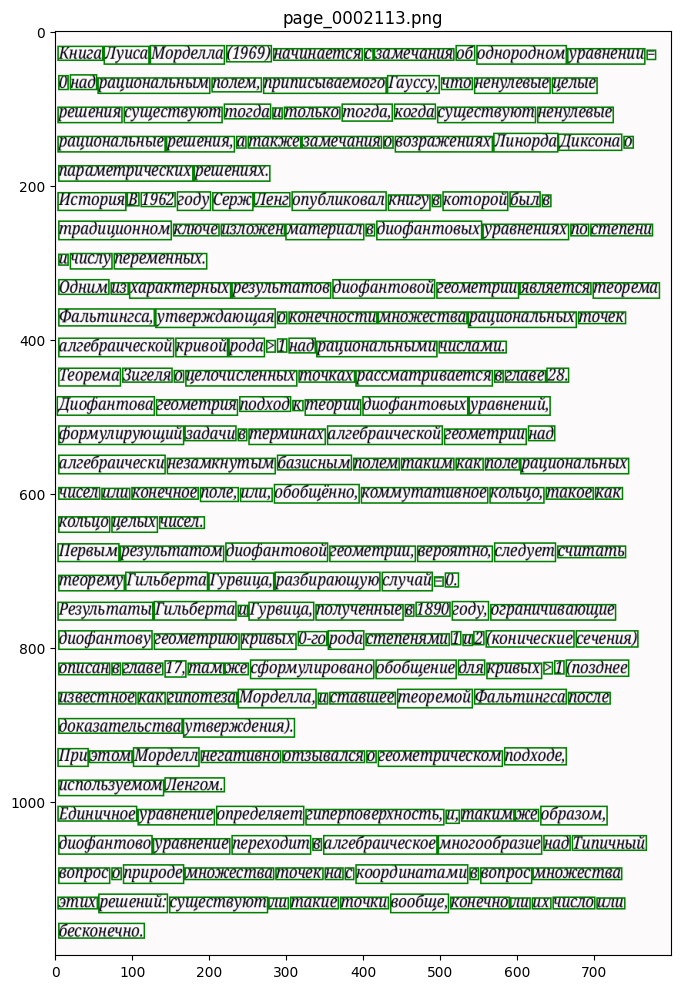

In [37]:
draw_boxes(path, annotations, image_size=12)